### HOMEWORK3 
Author: Francesca Calcagno 1000011144

In [24]:
import pandas as pd
import numpy as np

country_df = pd.read_csv("country.csv")
account_df = pd.read_csv("account-statement-1-1-2024-12-31-2024.csv", sep = ";")
symbols_df = pd.read_csv("symbols.csv", sep=";")

account_df = account_df.drop(columns= ['Unnamed: 5'])

country_df = country_df.dropna()
symbols_df = symbols_df.dropna()
account_df = account_df.dropna()

symbols_df['symbol'] = symbols_df['symbol'].str.strip()
account_df['Symbol'] = account_df['Symbol'].str.strip()

symbols_df['symbol'] = symbols_df['symbol'].str.upper()
account_df['Symbol'] = account_df['Symbol'].str.upper()


account_df['Date'] = pd.to_datetime(account_df['Date'], dayfirst=True) 

symbols_df.rename(columns={'symbol': 'Symbol'}, inplace=True)
symbols_df['Symbol'] = symbols_df['Symbol'].str.strip()

print(country_df.columns)
print(symbols_df.columns)


Index(['name', 'alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'region',
       'sub-region', 'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code'],
      dtype='object')
Index(['Symbol', 'company_name', 'sector', 'industry', 'country'], dtype='object')


* I uploaded the three main CSV files:

   * country.csv: contains the list of countries with geographic metadata.

   * account_df: is the main file with all transactions made in 2024.

   * symbols_df: contains the information about the securities (symbols, sector, industry, country…).

* For account_df and symbols_df, I specified the separator ; because the files are not standard CSVs (which use ,), but use semicolon as delimiter.

* I removed an empty and unnecessary column (Unnamed: 5) that was probably generated by Excel or by a bad export.

* I removed all rows with missing values using .dropna(), to ensure clean data for later merges.

* I cleaned white spaces in the Symbol columns by using .str.strip() — this avoids mismatches during joins caused by invisible leading/trailing spaces.

* I made all symbol names uppercase using .str.upper() to ensure consistency between files.

* I converted the Date column to datetime format using pd.to_datetime(..., dayfirst=True) to handle European-style dates (dd/mm/yyyy).
This conversion enables future time-based operations, such as extracting Year, Month, DayName, etc., when building the time dimension (dim_time).

In [25]:
dim_time = account_df[['Date']].copy()
dim_time['Date'] = dim_time['Date'].dt.date  
dim_time = dim_time.drop_duplicates().reset_index(drop=True)

dim_time['Year'] = pd.to_datetime(dim_time['Date']).dt.year
dim_time['Quarter'] = pd.to_datetime(dim_time['Date']).dt.quarter
dim_time['Month'] = pd.to_datetime(dim_time['Date']).dt.month
dim_time['DayName'] = pd.to_datetime(dim_time['Date']).dt.day_name()

dim_time = dim_time.sort_values('Date').reset_index(drop=True)

dim_time['date_id'] = dim_time.index + 1

dim_time = dim_time[['date_id', 'Date', 'Year', 'DayName']]

display(dim_time.head())



,date_id,Date,Year,DayName
0,1,2024-01-02,2024,Tuesday
1,2,2024-01-03,2024,Wednesday
2,3,2024-01-04,2024,Thursday
3,4,2024-01-05,2024,Friday
4,5,2024-01-08,2024,Monday


- I extract only the Date column and make a copy of it to build the dim_time table
- I eliminate any duplicate dates: each date must appear only once in the time dimension.
- I extract temporal attributes derived from each date: I choose only those useful for subsequent analysis
- I assign each date a unique ID (date_id) to use as the primary key of the dimension.
This way, when I create the fact table, I will be able to reference the dates efficiently and consistently.

In [26]:
dim_symbol = symbols_df[['Symbol', 'company_name', 'sector', 'industry', 'country']].drop_duplicates().reset_index(drop=True)

dim_symbol['Symbol'] = dim_symbol['Symbol'].str.strip()
dim_symbol['company_name'] = dim_symbol['company_name'].str.strip().str.title()
dim_symbol['sector'] = dim_symbol['sector'].str.strip().str.title()
dim_symbol['industry'] = dim_symbol['industry'].str.strip().str.title()
dim_symbol['country'] = dim_symbol['country'].str.strip().str.title()

dim_symbol['symbol_id'] = dim_symbol.index + 1

dim_symbol = dim_symbol[['symbol_id', 'Symbol', 'sector', 'industry']]

display(dim_symbol.head())



,symbol_id,Symbol,sector,industry
0,1,TEAM,Technology,Software - Application
1,2,WDS,Energy,Oil & Gas E&P
2,3,OSW,Consumer Cyclical,Leisure
3,4,ACGL,Financial Services,Insurance - Diversified
4,5,AGO,Financial Services,Insurance - Specialty


- I create a reduced and clean copy of the symbols_df dataset, keeping only the columns relevant for the analysis
- I eliminate any duplicate rows
- I clean all the texts from unwanted white spaces and I standardize the formatting
- I create a unique ID (symbol_id) for each row: it will be the primary key of the dimension

In [27]:
symbols_df['country'] = symbols_df['country'].astype(str).str.strip().str.title()

country_df.rename(columns={'name': 'Country'}, inplace=True)
country_df['Country'] = country_df['Country'].astype(str).str.strip().str.title()

used_countries = symbols_df[['country']].drop_duplicates().rename(columns={'country': 'Country'})

geo_df = used_countries.merge(country_df[['Country']], on='Country', how='left')

geo_df = geo_df.drop_duplicates().sort_values('Country').reset_index(drop=True)
geo_df['geography_id'] = geo_df.index + 1

dim_geography = geo_df[['geography_id', 'Country']]

display(dim_geography.head())


,geography_id,Country
0,1,Australia
1,2,Bahamas
2,3,Bermuda
3,4,Brazil
4,5,Canada


- I clean the country column in the symbols dataset:
   - .astype(str) ensures that all values ​​are treated as strings -
   - .str.strip() removes whitespace.
   - .str.title() makes formatting uniform (e.g. united states → United States).
- In the country_df dataset I rename the name column to Country for uniformity, then I clean it with the same techniques seen above.
- I extract the countries present in symbols_df
- I merge the used countries with those of the country_df file
- I remove any duplicates, sort alphabetically and generate an incremental ID

In [28]:
dim_transactiontype = account_df[['TransactionType']].drop_duplicates().reset_index(drop=True)

dim_transactiontype['TransactionType'] = dim_transactiontype['TransactionType'].str.strip().str.title()

dim_transactiontype = dim_transactiontype[dim_transactiontype['TransactionType'].isin(['Buy', 'Sell'])]

dim_transactiontype = dim_transactiontype.sort_values('TransactionType').reset_index(drop=True)
dim_transactiontype['transaction_type_id'] = dim_transactiontype.index + 1

dim_transactiontype = dim_transactiontype[['transaction_type_id', 'TransactionType']]

display(dim_transactiontype)




,transaction_type_id,TransactionType
0,1,Buy
1,2,Sell


- I extract the TransactionType column from the main dataset (account_df) and remove any duplicate values.
- I clean and format the values ​​correctly
- I filter to keep only the two relevant types
- I voluntarily eliminate other operations (e.g. Dividend) because they are not required in the project analyses.

In [29]:
transactions_df = account_df.copy()

transactions_df['Date'] = pd.to_datetime(transactions_df['Date'], dayfirst=True).dt.date
transactions_df = transactions_df.merge(dim_time[['Date', 'date_id']], on='Date', how='left')


transactions_df['Symbol'] = transactions_df['Symbol'].str.strip().str.upper()
transactions_df = transactions_df.merge(dim_symbol[['Symbol', 'symbol_id']], on='Symbol', how='left')


transactions_df['TransactionType'] = transactions_df['TransactionType'].str.strip().str.title()
transactions_df = transactions_df.merge(dim_transactiontype[['TransactionType', 'transaction_type_id']], on='TransactionType', how='left')

transactions_df = transactions_df.merge(symbols_df[['Symbol', 'country']], on='Symbol', how='left')
transactions_df['country'] = transactions_df['country'].astype(str).str.strip().str.title()
dim_geography['Country'] = dim_geography['Country'].astype(str).str.strip().str.title()
transactions_df = transactions_df.merge(dim_geography[['Country', 'geography_id']], left_on='country', right_on='Country', how='left')

transactions_df = transactions_df.dropna(subset=['symbol_id', 'date_id', 'transaction_type_id', 'geography_id'])

transactions_df['transaction_id'] = range(1, len(transactions_df) + 1)


Fact_Transactions = transactions_df[[
    'transaction_id',
    'symbol_id',
    'date_id',
    'transaction_type_id',
    'geography_id',
    'Unit'
]]


Fact_Transactions = Fact_Transactions.astype({
    'transaction_id': 'int',
    'symbol_id': 'int',
    'date_id': 'int',
    'transaction_type_id': 'int',
    'geography_id': 'int'
})


display(Fact_Transactions.head())


,transaction_id,symbol_id,date_id,transaction_type_id,geography_id,Unit
0,1,284,8,1,32,1605.0
1,2,284,17,2,32,1605.0
2,3,284,7,2,32,914.0
3,4,4,11,1,3,646.0
4,5,258,11,2,26,646.0


The goal is to Build a fact table containing all transactions with links (foreign keys) to the Time, Symbol, TransactionType and Geography dimensions, plus the Unit measure (i.e. the number of units exchanged).

- I start from a copy of the main dataset with all transactions (account_df), so as not to alter the original and work on an independent dataframe.

- I convert Date back to date format (only day, month, year) and merge with the time dimension dim_time to obtain date_id. This allows me to connect each transaction to a specific day, in normalized form (via ID).
- I clean the Symbol column and merge with dim_symbol to obtain symbol_id. In this way I connect each transaction to a security (stock, crypto, etc.) via
- I normalize the TransactionType values ​​and merge with dim_transactiontype to obtain transaction_type_id. So each transaction will be identified as BUY or SELL by numeric ID.
- I do an intermediate merge with symbols_df to retrieve the country associated with the symbol (country). Then I connect it to dim_geography to obtain geography_id. It is used to know in which country the company associated with the stock is located, so as to be able to do geographical analysis.
- I assign a unique ID to each transaction, which becomes the primary key of the fact table.
- I build the actual fact table: a compact and related table, with:
    - 5 foreign keys (the dimensions),
    - 1 measure: Unit, that is the number of units purchased or sold.
- I convert all the ID type columns to integers, so as to save memory and make the joins more robust.

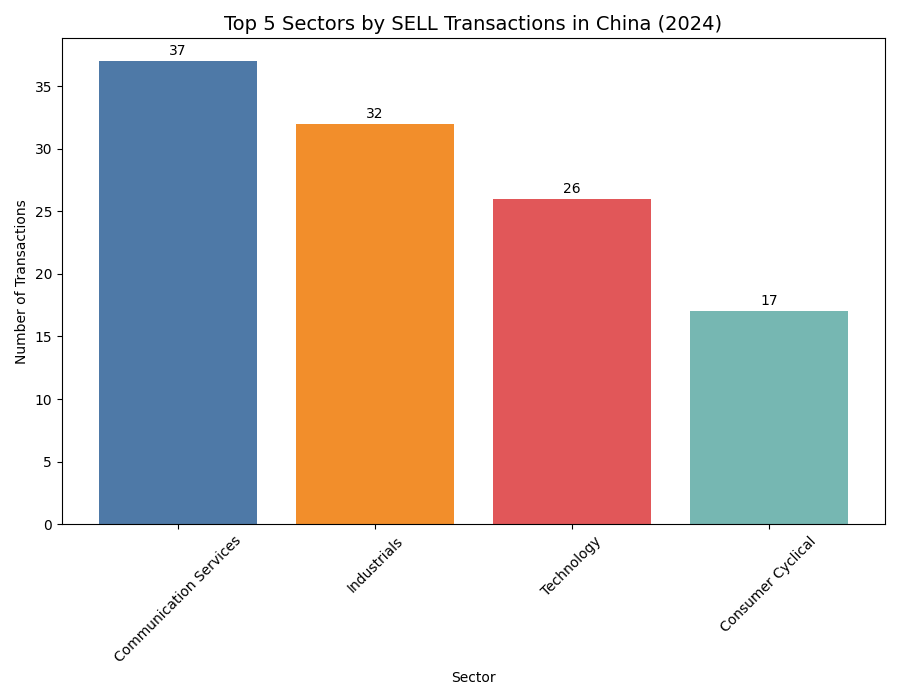

In [30]:
df_join = Fact_Transactions \
    .merge(dim_time, on='date_id', how='left') \
    .merge(dim_symbol, on='symbol_id', how='left') \
    .merge(dim_transactiontype, on='transaction_type_id', how='left') \
    .merge(dim_geography, on='geography_id', how='left')

filtered = df_join[
    (df_join['TransactionType'].str.upper() == 'SELL') &
    (df_join['Country'] == 'China') &
    (df_join['Year'] == 2024)
]

top_sectors = filtered.groupby('sector').size().sort_values(ascending=False).head(5).reset_index(name='transaction_count')


import matplotlib.pyplot as plt
from IPython.display import Image, display

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

plt.figure(figsize=(9, 7))
bars = plt.bar(top_sectors['sector'], top_sectors['transaction_count'], color=colors[:len(top_sectors)])
plt.title('Top 5 Sectors by SELL Transactions in China (2024)', fontsize=14)
plt.xlabel('Sector')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("top5_sectors_sell_china_fact.png")
plt.close()

display(Image("top5_sectors_sell_china_fact.png"))


- I merge the fact table with all the dimensions, to enrich each transaction row with:

    - sector name from dim_symbol

    - transaction type (TransactionType) from dim_transactiontype

    - year (Year) from dim_time

    - country (Country) from dim_geography

This allows us to have in a single dataframe all the useful information for filters and analysis.

- I apply three conditions:

    - SELL type transactions

    - Located in China

    - Occurred in 2024

This isolates the subgroup of interest to analyze: sales occurred in China during the year.

- I group the filtered data by sector and accounts and how many transactions there are for each.
- I sort in decreasing order.
- I take only the top 5 sectors.
- I create the plot

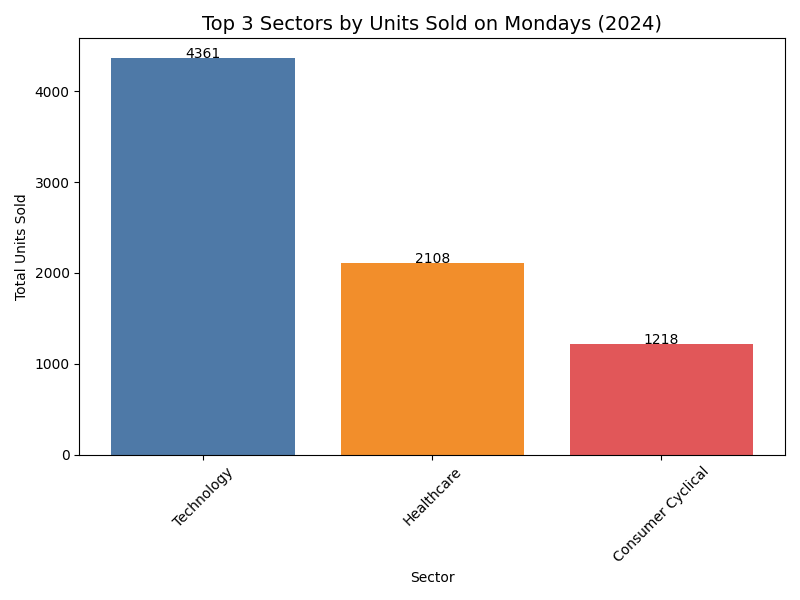

In [31]:
df_join2 = Fact_Transactions \
    .merge(dim_time, on='date_id', how='left') \
    .merge(dim_symbol, on='symbol_id', how='left') \
    .merge(dim_transactiontype, on='transaction_type_id', how='left') \
    

    
filtered = df_join2[
    (df_join2['TransactionType'].str.upper() == 'SELL') &
    (df_join2['Year'] == 2024) &
    (df_join2['DayName'].str.upper() == 'MONDAY')
]

top_sectors = filtered.groupby('sector')['Unit'].sum().sort_values(ascending=False).head(3).reset_index(name='total_units')


import matplotlib.pyplot as plt
from IPython.display import Image, display

colors = ['#4E79A7', '#F28E2B', '#E15759']

plt.figure(figsize=(8, 6))
bars = plt.bar(top_sectors['sector'], top_sectors['total_units'], color=colors[:len(top_sectors)])
plt.title('Top 3 Sectors by Units Sold on Mondays (2024)', fontsize=14)
plt.xlabel('Sector')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("top3_sectors_sell_mondays_2024.png")
plt.close()

display(Image("top3_sectors_sell_mondays_2024.png"))


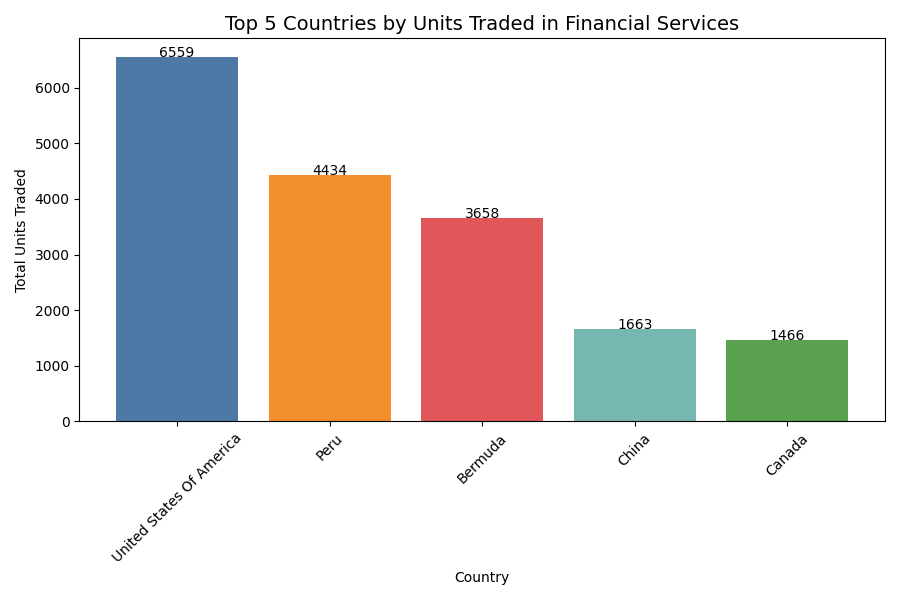

In [32]:
df_join3 = Fact_Transactions \
    .merge(dim_symbol, on='symbol_id', how='left') \
    .merge(dim_geography, on='geography_id', how='left')


filtered = df_join3[df_join3['sector'].str.strip().str.lower() == 'financial services']


top_countries = filtered.groupby('Country')['Unit'].sum().sort_values(ascending=False).head(5).reset_index(name='total_units')

import matplotlib.pyplot as plt
from IPython.display import Image, display

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

plt.figure(figsize=(9, 6))
bars = plt.bar(top_countries['Country'], top_countries['total_units'], color=colors[:len(top_countries)])
plt.title('Top 5 Countries by Units Traded in Financial Services', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Total Units Traded')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("top5_countries_financial_services.png")
plt.close()

display(Image("top5_countries_financial_services.png"))


In [33]:
df_join.to_csv("final_joined_dataset.csv", index=False)

print(df_join.columns)


Index(['transaction_id', 'symbol_id', 'date_id', 'transaction_type_id',
       'geography_id', 'Unit', 'Date', 'Year', 'DayName', 'Symbol', 'sector',
       'industry', 'TransactionType', 'Country'],
      dtype='object')
